# Running the sampler locally with multiprocessing

We'll generate some fake radial velocity measurements of a source and run _The Joker_ using Python's `multiprocessing` package. Parallelizing the rejection sampling will generally speed up the sampling by a factor equal to the number of cores (evaluating the marginal likelihood for each of the prior samples "embarassingly parallel").

In [1]:
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
%matplotlib inline

from twobody import KeplerOrbit, Barycenter
from thejoker import RVData, JokerPrior, TheJoker
from thejoker.plot import plot_rv_curves

rnd = np.random.RandomState(seed=123)

For data, we'll generate simulated observations of the exoplanet GJ 876 b (with parameters taken from [exoplanets.org](http://exoplanets.org/detail/GJ_876_b)):

In [2]:
t0 = Time(2450546.80, format='jd', scale='utc')

truth = dict()
truth['P'] = 61.1166 * u.day
truth['a'] = 0.2081*u.au * (1.95*u.Mjup) / (0.320*u.Msun)
truth['e'] = 0.0324 * u.one
phi0 = 2*np.pi*t0.tcb.mjd / truth['P'].to(u.day).value
truth['M0'] = (phi0 % (2*np.pi)) * u.radian
truth['omega'] = 50.3 * u.degree
truth['barycenter'] = Barycenter(radial_velocity=-1.52 * u.km/u.s)

orbit = KeplerOrbit(**truth, 
                    Omega=0*u.deg, i=90*u.deg) # these angle don't matter for RV

We generate the data by sampling times uniformly over 350 days relative to an arbitrary epoch in MJD:

In [3]:
n_data = 6
t = Time(55557. + rnd.uniform(0, 350, n_data), 
         format='mjd', scale='tcb')
t.sort()
rv = orbit.radial_velocity(t)

err = np.full_like(t, 25) * u.m/u.s
rv = rv + rnd.normal(0, err.value)*err.unit

Now we create an `RVData` object to store the "observations":

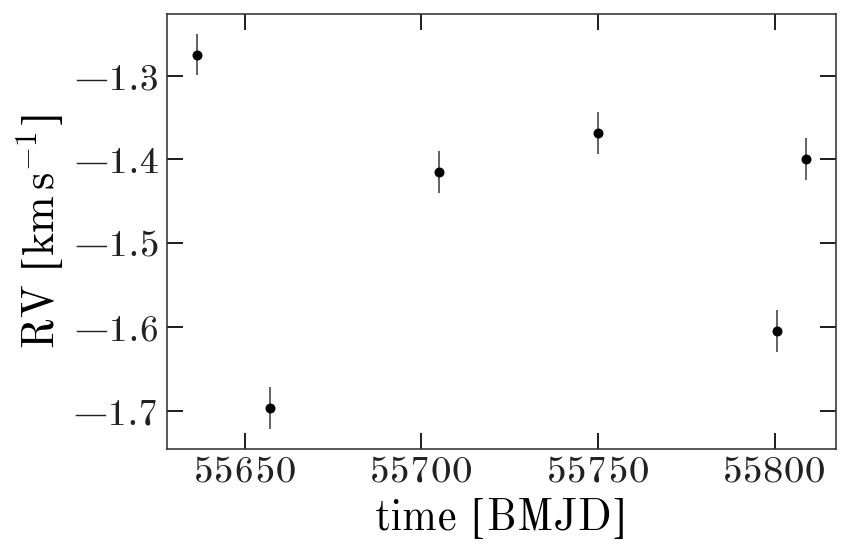

In [4]:
data = RVData(t, rv, err)
ax = data.plot()

We'll set the period range to be somewhat more restricted since (in practice, you should use a very large range of periods):

In [6]:
prior = JokerPrior.default(P_min=8*u.day, P_max=256*u.day, 
                           sigma_K0=30*u.km/u.s,
                           sigma_v=100*u.km/u.s)

To run using `multiprocessing`, we have to create a `schwimmbad.MultiPool` instance to pass in to `TheJoker`. In this case, we only need the pool to do the rejection sampling, so we'll use a context manager to make sure the worker processes are all cleaned up:

In [10]:
prior_samples = prior.sample(size=1_000_000)

In [11]:
%%time
with schwimmbad.MultiPool() as pool:
    joker = TheJoker(prior, pool=pool)
    samples = joker.rejection_sample(data, prior_samples)
    print(len(samples))

122
CPU times: user 940 ms, sys: 125 ms, total: 1.07 s
Wall time: 1.33 s


Now we'll plot the samples in various projections of the parameters:

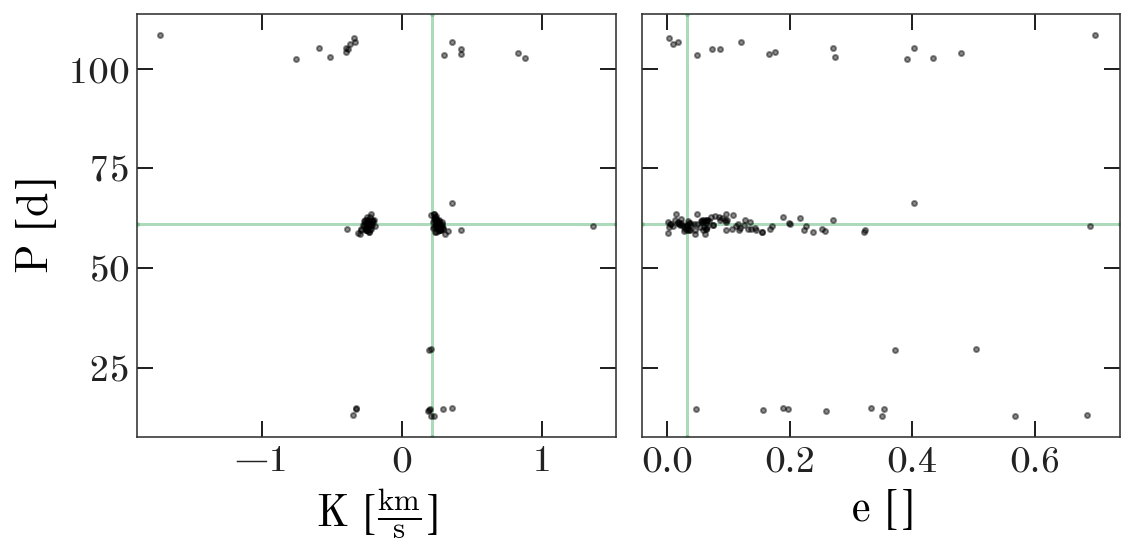

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

y_key = 'P'
y_unit = u.day
x_keys = ['K', 'e']
x_units = [u.km/u.s, u.one]

for ax,x_key,x_unit in zip(axes, x_keys, x_units):
    ax.scatter(samples[x_key].to(x_unit).value, 
               samples[y_key].to(y_unit).value,
               marker='.', color='k', alpha=0.45)
    ax.set_xlabel(r"{} [{}]".format(x_key, x_unit.to_string('latex')))
    
    ax.axvline(getattr(orbit, x_key).to(x_unit).value, 
               zorder=-100, color='#31a354', alpha=0.4)
    ax.axhline(getattr(orbit, y_key).to(y_unit).value, 
               zorder=-100, color='#31a354', alpha=0.4)
    
axes[0].set_ylabel(r"{} [{}]".format(y_key, y_unit.to_string('latex')))

fig.tight_layout()

And here we'll plot RV curves for the posterior samples over the data:

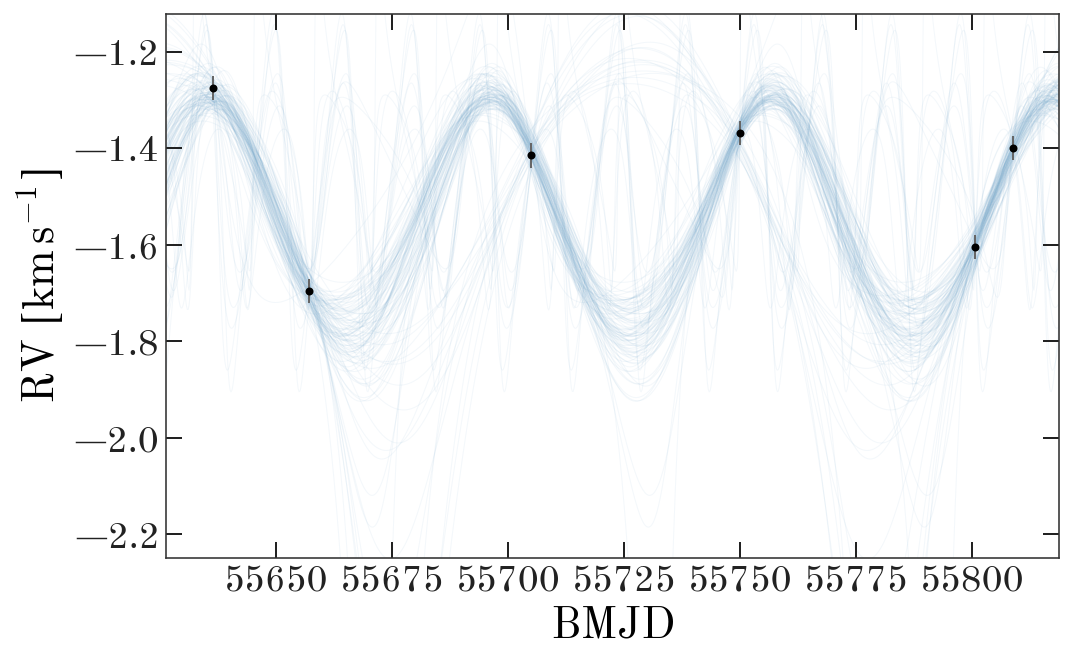

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,5)) 
t_grid = np.linspace(data.t.mjd.min()-10, data.t.mjd.max()+10, 1024)
fig = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
                     plot_kwargs=dict(color='#74a9cf', zorder=-100))